In [18]:
!pip install transformers
!pip install transformers_interpret
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import AutoTokenizer, AdamW, get_scheduler, AutoModelForSequenceClassification
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cpu


In [20]:
train_dataset_path = "/content/train_task_b_only_with_emojis_removed.txt"
test_dataset_path = "/content/test_task_b_only_with_emojis_removed.txt"

In [21]:
train_df = pd.read_csv(train_dataset_path, sep="\t")
test_df = pd.read_csv(test_dataset_path, sep="\t")
train_df, validation_df = train_test_split(train_df, test_size=0.2)

train_df.head()

,index,label,text
395,3713,1,Tryna learn to skate tonight! #pennyboard #ska...
3,28,0,The rain has made extra extra lazy
18,168,0,@SincerelyTumblr: One day I want to travel wit...
131,1176,0,Currently a bus wanker. I hate people #stinks...
118,1089,1,"Hi Orgabeh, so we meet again. I think you're m..."


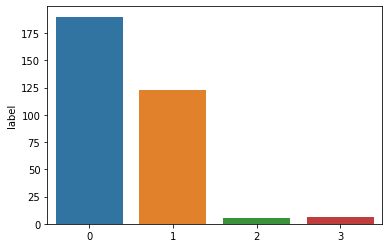

In [22]:
value_counts = train_df["label"].value_counts()
sns.barplot(value_counts.index, value_counts)

In [23]:
class SarcasticSentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        if len(sentences) != len(labels):
            raise ValueError("Sentences and labels should have the same number of elements.")

        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index: int):
        inputs = self.tokenizer(self.sentences[index],
                                truncation=True,
                                pad_to_max_length=True,
                                return_tensors="pt",
                                max_length=self.max_len)

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[index], dtype=torch.long)
        }

    def __len__(self):
        return len(self.sentences)

In [24]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", normalization=True)

In [25]:
train_dataset = SarcasticSentenceDataset(sentences=train_df["text"].tolist(),
                                         labels=train_df["label"].tolist(),
                                         tokenizer=tokenizer)

validation_dataset = SarcasticSentenceDataset(sentences=validation_df["text"].tolist(),
                                         labels=validation_df["label"].tolist(),
                                         tokenizer=tokenizer)

test_dataset = SarcasticSentenceDataset(sentences=test_df["text"].tolist(),
                                        labels=test_df["label"].tolist(),
                                        tokenizer=tokenizer)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [27]:
from tqdm.auto import tqdm
import copy


def train(model,
          train_loader,
          eval_loader,
          device,
          lr=5e-5,
          num_epochs=5):
    num_training_steps = len(train_loader) * num_epochs
    optimizer, lr_scheduler = setup_optimizer_and_scheduler(model,
                                                            lr,
                                                            0,
                                                            num_training_steps)

    progress_bar = tqdm(range(num_training_steps))

    best_f1 = 0
    best_epoch = -1
    best_params = copy.deepcopy(model.state_dict())
    patience = 0

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)

        metrics = evaluate(model, eval_loader, device)
        print(f"validation accuracy: {metrics['accuracy']}\n"
              f"validation precision: {metrics['precision']}\n"
              f"validation recall: {metrics['recall']}\n"
              f"validation f1: {metrics['f1']}\n")

        if metrics["f1"] > best_f1:
            best_f1 = metrics["f1"]
            best_epoch = epoch
            best_params = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1

        print(f"patience: {patience}\n")
        if patience == 3:
            break

    print(f"best epoch: {best_epoch}\n"
          f"best f1: {best_f1}\n")

    model.load_state_dict(best_params)
    return model


def setup_optimizer_and_scheduler(model, lr, num_warmup_steps, num_training_steps):
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_scheduler(name="linear",
                              optimizer=optimizer,
                              num_warmup_steps=num_warmup_steps,
                              num_training_steps=num_training_steps)
    return optimizer, scheduler


def evaluate(model, eval_loader, device):
    model.eval()
    labels_list = []
    preds_list = []
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            _, preds = torch.max(outputs.logits, dim=1, keepdim=False)
            labels_list.extend(batch["labels"].cpu().numpy().tolist())
            preds_list.extend(preds.cpu().numpy().tolist())

    return compute_metrics(labels_list, preds_list)


def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

In [28]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [29]:
model = train(model,
              train_loader,
              validation_loader,
              device,
              num_epochs=10,
              lr=5e-5)

  0%|          | 0/410 [00:00<?, ?it/s]

validation accuracy: 0.6829268292682927
validation precision: 0.46340960626674915
validation recall: 0.46820929747759016
validation f1: 0.4600737100737102

patience: 0

validation accuracy: 0.6829268292682927
validation precision: 0.49336455893832937
validation recall: 0.4627892432770482
validation f1: 0.44836601307189544

patience: 1

validation accuracy: 0.6707317073170732
validation precision: 0.45646215475437485
validation recall: 0.4604961434229727
validation f1: 0.45

patience: 2

validation accuracy: 0.7195121951219512
validation precision: 0.48708333333333337
validation recall: 0.490097977902856
validation f1: 0.48382603312180783

patience: 0

validation accuracy: 0.7560975609756098
validation precision: 0.5347368421052632
validation recall: 0.5136543673129039
validation f1: 0.504889455782313

patience: 0

validation accuracy: 0.7682926829268293
validation precision: 0.5260683760683761
validation recall: 0.5230352303523035
validation f1: 0.5164407043789933

patience: 0

validat

test accuracy: 0.7272727272727273
test precision: 0.3572916666666667
test recall: 0.3993265993265993
test f1: 0.3706709172583683



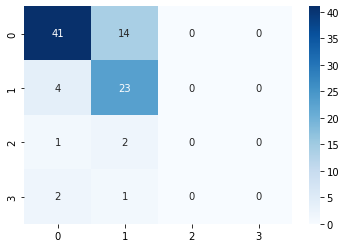

In [30]:
metrics = evaluate(model, test_loader, device)
print(f"test accuracy: {metrics['accuracy']}\n"
      f"test precision: {metrics['precision']}\n"
      f"test recall: {metrics['recall']}\n"
      f"test f1: {metrics['f1']}\n")

sns.heatmap(metrics["confusion_matrix"], annot=True, cmap='Blues', fmt="d")

In [ ]:
from transformers_interpret import MultiLabelClassificationExplainer

cls_explainer = MultiLabelClassificationExplainer(model, tokenizer)
word_attributions = cls_explainer("Perfect time to get really sick  😫😷")
cls_explainer.visualize()

In [32]:
torch.save(model.state_dict(), "model.pth")
print("model params saved")

model params saved
